# TM10007 Assignment

In [8]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

## Load and analyse data

The number of samples: 246
The number of columns: 494
<class 'pandas.core.frame.DataFrame'>
Index: 246 entries, GIST-001_0 to GIST-246_0
Columns: 494 entries, label to PREDICT_original_phasef_phasesym_entropy_WL3_N5
dtypes: float64(468), int64(25), object(1)
memory usage: 951.3+ KB
None
                                                    PREDICT_original_sf_compactness_avg_2.5D  \
PREDICT_original_sf_compactness_avg_2.5D                                                True   
PREDICT_original_sf_compactness_std_2.5D                                               False   
PREDICT_original_sf_rad_dist_avg_2.5D                                                  False   
PREDICT_original_sf_rad_dist_std_2.5D                                                  False   
PREDICT_original_sf_roughness_avg_2.5D                                                 False   
...                                                                                      ...   
PREDICT_original_phasef_phasesym_peak_po

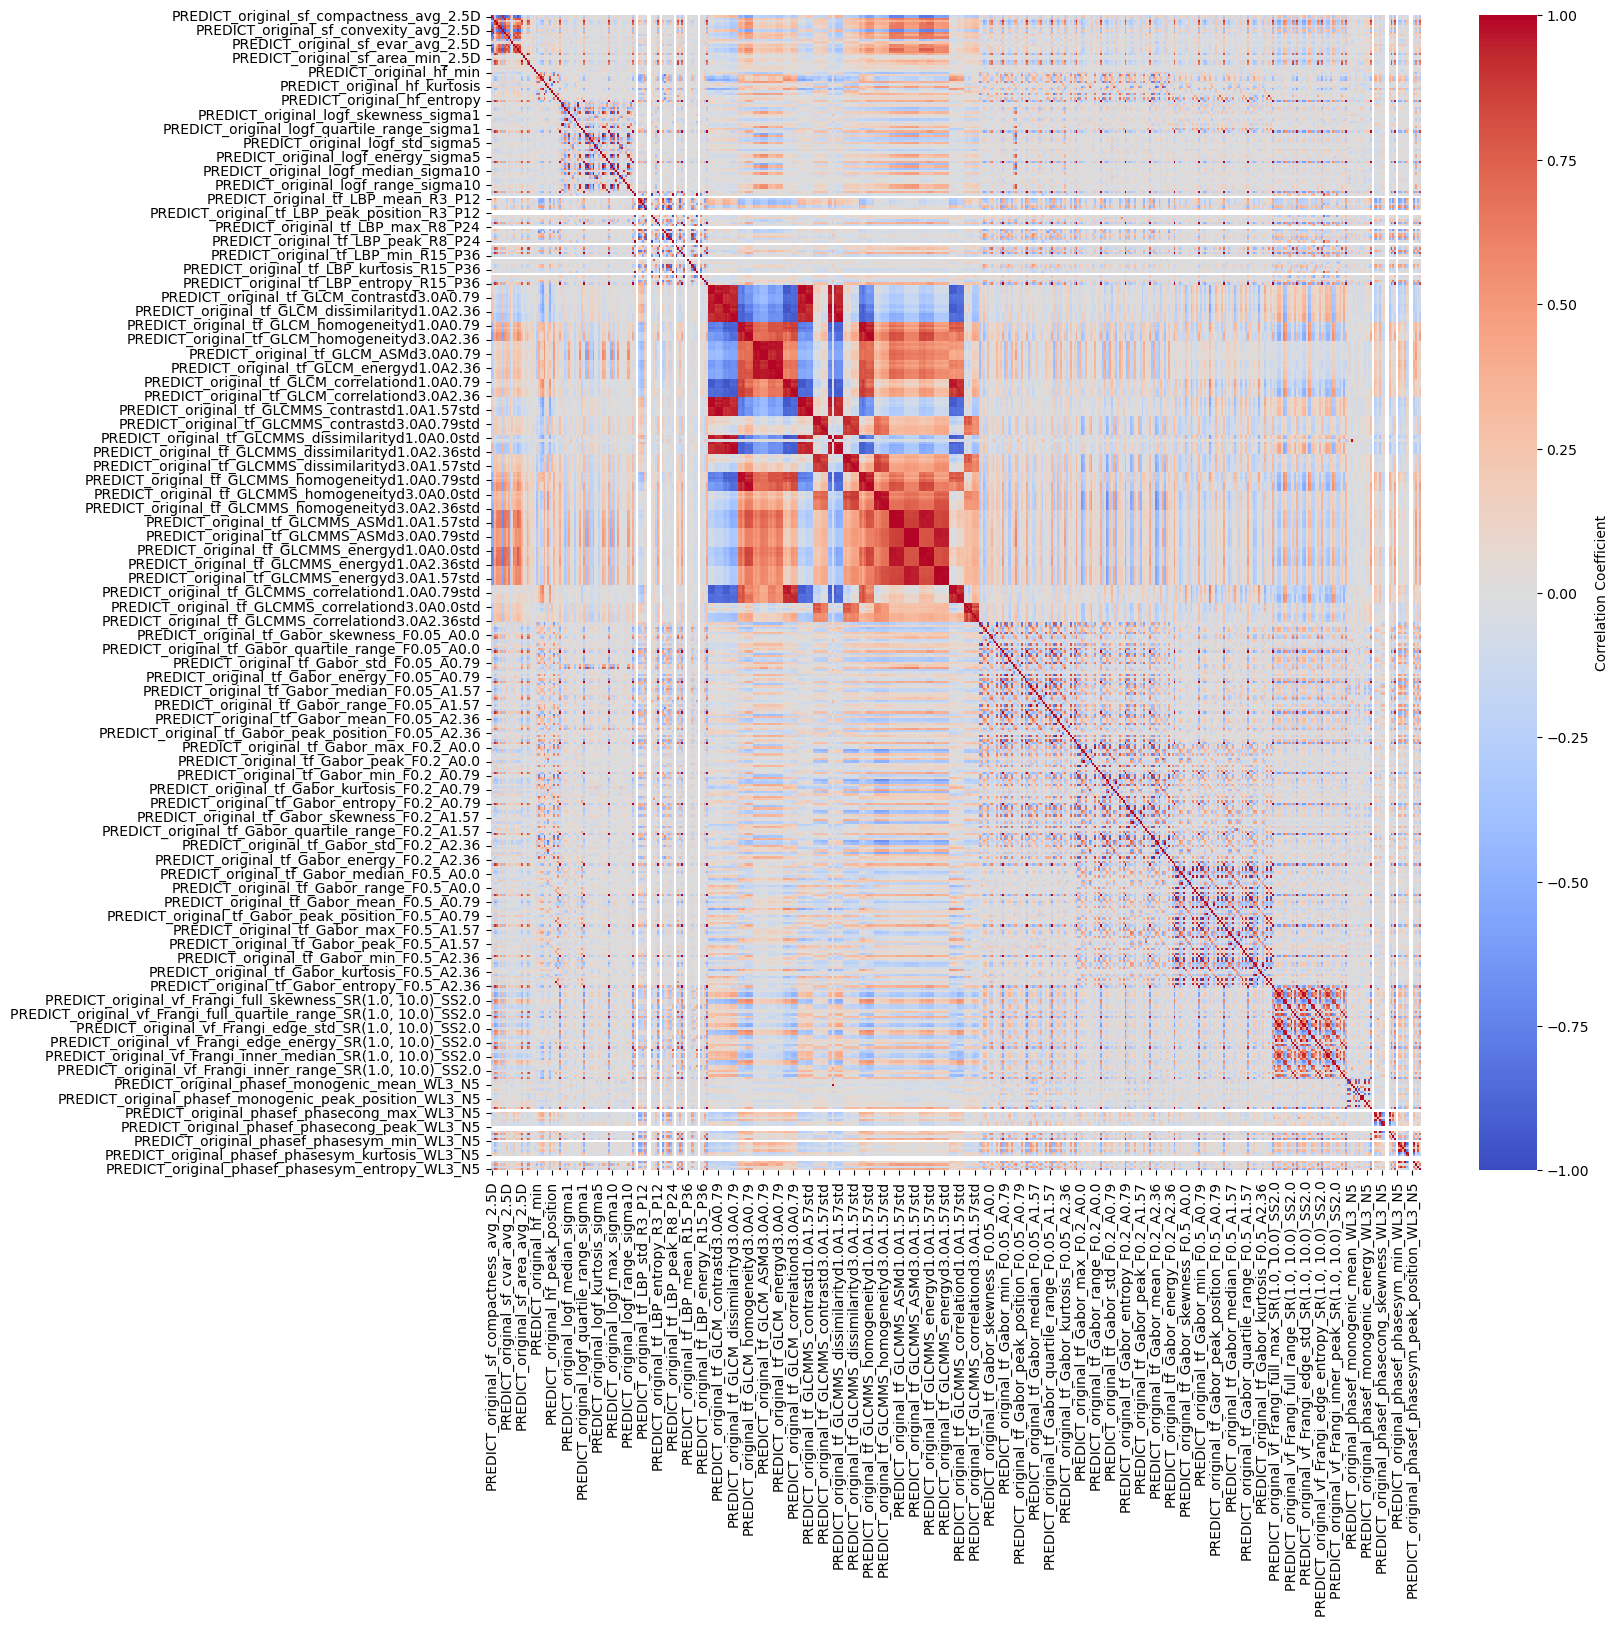

In [10]:
from load_data import load_data
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd

# Code used to load the original data and split into train and test set
# Was only run once at the start to create test and train dataset

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

print(data.info())

# Make a correlation matrix to analyse the correlation between the features
correlation_matrix = data.drop(columns=['label']).corr()

print(correlation_matrix > 0.9)

# Heatmap for the entire correlation matrix (for large datasets, consider reducing the size)
plt.figure(figsize=(15, 15))  # Adjust size as needed
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", cbar_kws={'label': 'Correlation Coefficient'})
plt.show()

# Standardize the data
labels = data['label']
values = data.drop(columns=['label'])

scaler = StandardScaler()
scaled_values = scaler.fit_transform(values)

values = pd.DataFrame(scaled_values, columns=values.columns)

# Convert 'GIST' and 'non-GIST' to numeric values
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)  # This will convert 'GIST' to 1, 'non-GIST' to 0


## Feature selection and dimension reduction

In [11]:
# First we remove NaNs by averaging
values = values.fillna(values.mean())

# First we remove features with 0 variance
print(values.shape)

print(f'We removed {values.loc[:, values.var() == 0].shape[1]} columns without any variance')
values = values.loc[:, values.var() != 0]

print(values.shape)



(246, 493)
We removed 13 columns without any variance
(246, 480)


## Elastic net selection

In [12]:
from sklearn.linear_model import LogisticRegressionCV
import numpy as np

def elastic_net_feature_selection(training_values, training_labels):

    elastic_net = LogisticRegressionCV(
    penalty="elasticnet",
    solver="saga",         
    l1_ratios=[0.1, 0.5, 0.9],  
    cv=5,                 
    max_iter=5000,         
    random_state=42
    )   

    elastic_net.fit(training_values, training_labels)

    print(elastic_net.coef_)

    selected_features = np.where(elastic_net.coef_ != 0)[0]

    print(f"Selected features: {selected_features}")

    training_values = training_values.iloc[:, selected_features]

    return training_values, training_labels

## Random forest

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

def train_random_forest(training_values, training_labels):
    # Initialize the Random Forest Classifier
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        max_features='sqrt',
        min_samples_leaf=5,
        random_state=42
    )

    trained_model = rf_model.fit(training_values, training_labels)

    feature_importances = trained_model.feature_importances_

    feature_importance_df = pd.DataFrame({
        'Feature': training_values.columns,
        'Importance': feature_importances
    })

    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

    top_features = feature_importance_df.head(20)['Feature'].values

    data_selected = training_values[top_features]
    labels_selected = training_labels

    final_model = rf_model.fit(data_selected, labels_selected)
    cv_scores = cross_val_score(rf_model, data_selected, labels_selected, cv=5)

    return final_model, cv_scores.mean()

## KNN-classifier

In [14]:
from sklearn.neighbors import KNeighborsClassifier

def KNN(training_values, training_labels):
    training_values, training_labels = elastic_net_feature_selection(training_values, training_labels)

    print('Test')
    print(training_values.shape)

    knn = KNeighborsClassifier(n_neighbors=50, weights = 'distance')

    knn.fit(training_values, training_labels)

    cv_scores = cross_val_score(knn, training_values, training_labels, cv=5)

    return cv_scores.mean()


## SVM

In [ ]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import learning_curve

def SVM(training_values, training_labels):
    clf = SVC()

    # Define hyperparameters
    param_grid = {
        'C': [0.1, 0.5, 1, 5, 10, 25, 50], 
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'gamma': ['scale', 'auto', 0.01, 0.1, 1],
        'degree': [2, 3, 4],
    }

    # Optimize model with n_iter=100 to find best hyperparameters
    random_search = RandomizedSearchCV(
        clf, param_distributions=param_grid, n_iter=100, cv=5, n_jobs=-1, random_state=42
    )
    random_search.fit(training_values, training_labels)
    best_params = random_search.best_params_
    print(f"Best hyperparameters found: {best_params}")

    # Look at the performance with different iteration values
    iterations = [10, 20, 30, 40, 50, 75, 100]
    scores = []

    for i in iterations:

        random_search_iter = RandomizedSearchCV(
            clf, param_distributions=param_grid, n_iter=i, cv=5, n_jobs=-1, random_state=42
        )

        random_search_iter.fit(training_values, training_labels)
        best_model = random_search_iter.best_estimator_
        cv_score = cross_val_score(best_model, training_values, training_labels, cv=5).mean()
        
        scores.append(cv_score)

    # Plot results
    plt.figure(figsize=(8,5))
    plt.plot(iterations, scores, marker='o', linestyle='-', color='b', label="Validation Accuracy")
    plt.xlabel("Number of Iterations")
    plt.ylabel("Cross-Validation Accuracy")
    plt.title("SVM Performance vs. Number of Iterations")
    plt.legend()
    plt.grid(True)
    plt.show()

    train_sizes, train_scores, validation_scores = learning_curve(
        best_model, training_values, training_labels, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )

    # Calculate the mean and standard deviation of the scores
    train_mean = train_scores.mean(axis=1)
    validation_mean = validation_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    validation_std = validation_scores.std(axis=1)

    # Plot the learning curve
    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_mean, label="Training score", color="r")
    plt.plot(train_sizes, validation_mean, label="Cross-validation score", color="g")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.2)
    plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color="g", alpha=0.2)

    # Adding labels and title
    plt.xlabel("Training Size")
    plt.ylabel("Score")
    plt.ylim(0.3, 1.01)
    plt.title("Learning Curve for SVM")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

    return cv_score.mean()

## Linear classifier

In [100]:
# Linear classifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score,f1_score
from load_data import load_data

def linear_classifier(training_values,training_labels):
    # # === LDA model trainen ===
    lda = LinearDiscriminantAnalysis()
    lda.fit(training_values, training_labels)  # Model trainen met training set
    
    # === Model voorspellingen maken ==
    y_pred_train = lda.predict(training_values)  # Voorspellen op de training set
    y_probs_train = lda.predict_proba(training_values)[:, 1]  # Voor ROC-AUC (trainset)
    
    # Evaluatiemetrics berekenen voor training set
    accuracy_train = accuracy_score(training_labels, y_pred_train)
    precision_train = precision_score(training_labels, y_pred_train)
    recall_train = recall_score(training_labels, y_pred_train)
    f1_train = f1_score(training_labels, y_pred_train)
    roc_auc_train = roc_auc_score(training_labels, y_probs_train)
    # Print de resultaten voor zowel training als test set
    print(f"🔹 **LDA Model Evaluatie (Training Set):**")
    print(f"   Accuracy:  {accuracy_train:.4f}")
    print(f"   Precision: {precision_train:.4f}")
    print(f"   Recall:    {recall_train:.4f}")
    print(f"   F1-score:  {f1_train:.4f}")
    print(f"   ROC-AUC:   {roc_auc_train:.4f}")
    
    return accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


## Try the different classifiers for 5 different folds


=== Fold 0 ===
Best hyperparameters found: {'kernel': 'poly', 'gamma': 0.01, 'degree': 2, 'C': 0.5}


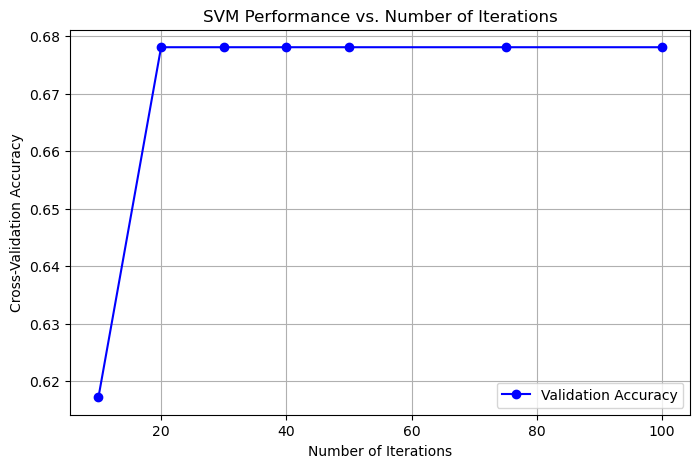

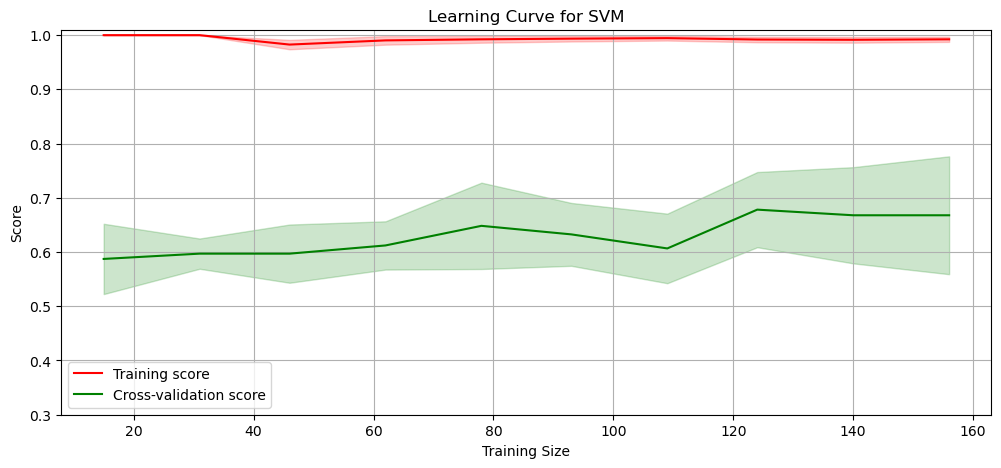

Fold 0 - SVM Score: 0.6781

=== Fold 1 ===
Best hyperparameters found: {'kernel': 'rbf', 'gamma': 'auto', 'degree': 3, 'C': 1}


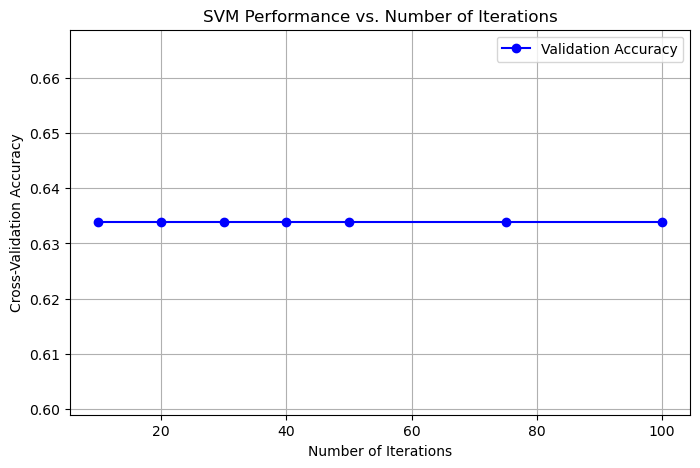

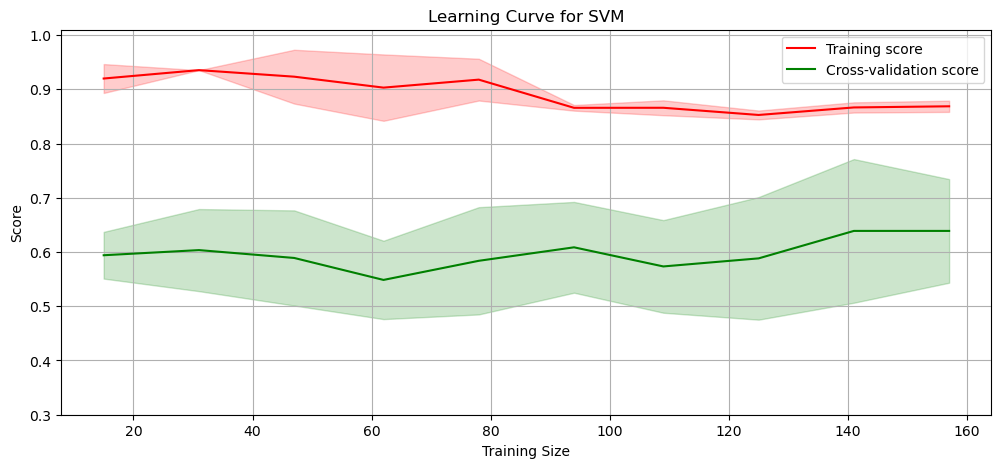

Fold 1 - SVM Score: 0.6338

=== Fold 2 ===
Best hyperparameters found: {'kernel': 'sigmoid', 'gamma': 0.01, 'degree': 3, 'C': 0.1}


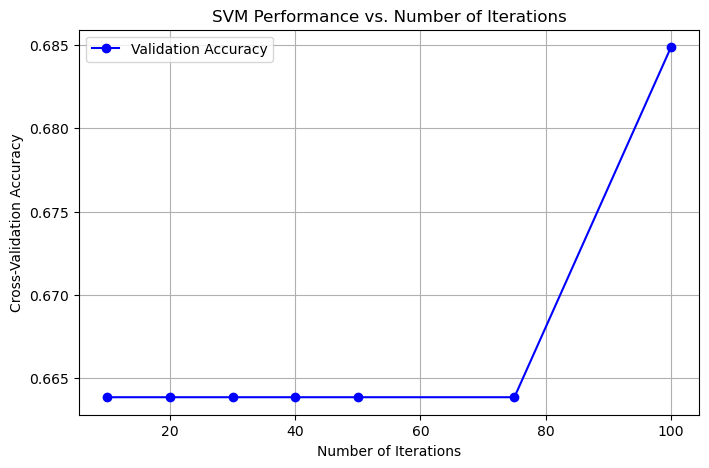

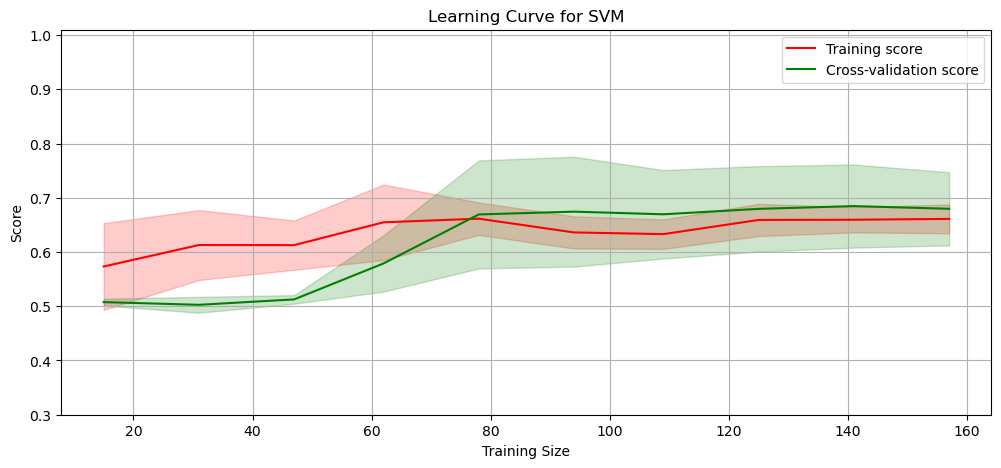

Fold 2 - SVM Score: 0.6849

=== Fold 3 ===
Best hyperparameters found: {'kernel': 'sigmoid', 'gamma': 0.01, 'degree': 3, 'C': 0.1}


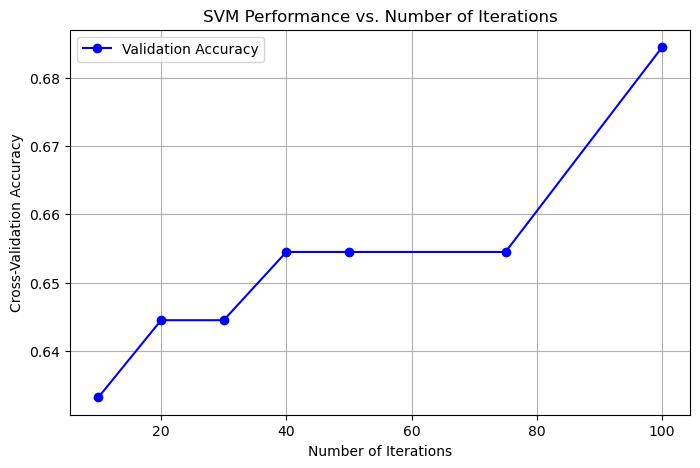

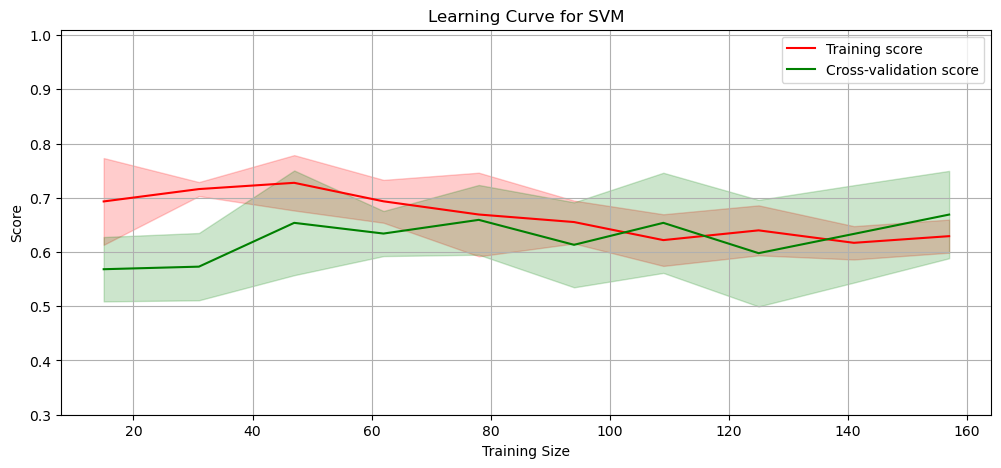

Fold 3 - SVM Score: 0.6845

=== Fold 4 ===
Best hyperparameters found: {'kernel': 'sigmoid', 'gamma': 'auto', 'degree': 2, 'C': 10}


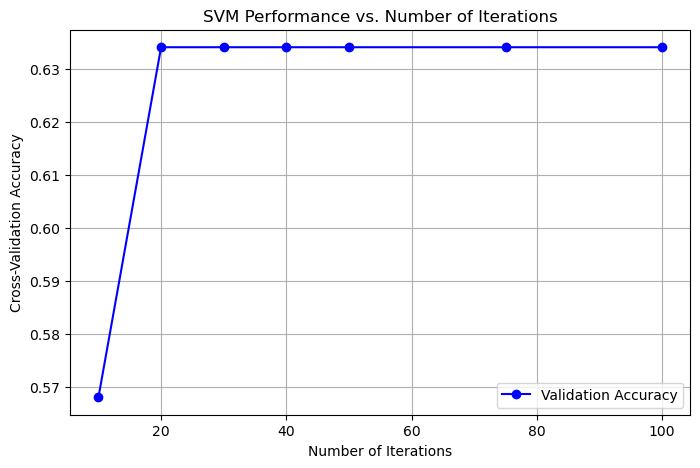

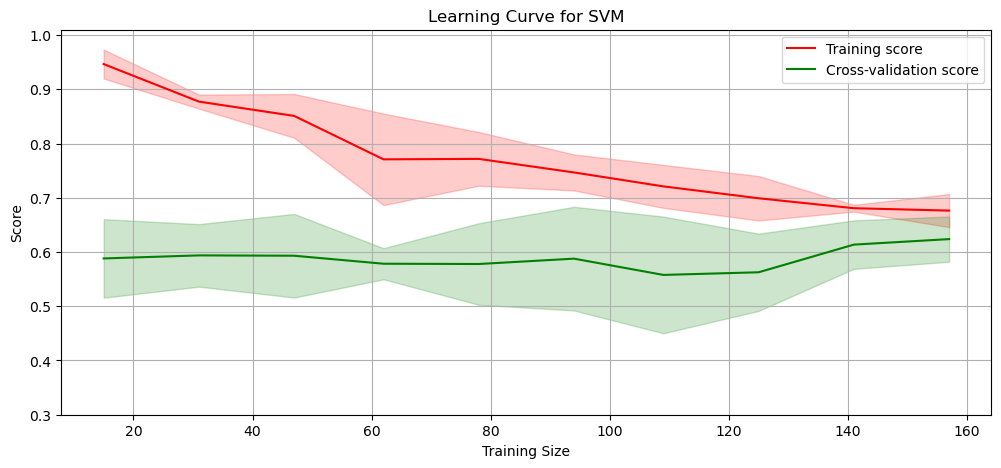

Fold 4 - SVM Score: 0.6341


In [101]:
from sklearn.model_selection import StratifiedKFold

# 5-fold cross-validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(skf.split(values, labels)):
    print(f"\n=== Fold {fold} ===")

    training_values = values.iloc[train_index]
    training_labels = labels[train_index]

    # print(training_labels)

    test_values = values.iloc[test_index]
    test_labels = labels[test_index]

    # forest_model, forest_score = train_random_forest(training_values, training_labels)
    # print(f"Fold {fold} - Random Forest Score: {forest_score:.4f}")

    # knn_score = KNN(training_values, training_labels)
    # print(f"Fold {fold} - KNN Score: {knn_score:.4f}")

    svm_score = SVM(training_values, training_labels)
    print(f"Fold {fold} - SVM Score: {svm_score:.4f}")
    
#)